In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Time demand patterns
In this notebook we want to examine how the demand for the bike rentals varies over time.

In [142]:
sns.set_theme(style="darkgrid", rc={'figure.figsize': (9, 5)})

# Global variables
df_boston = pd.read_csv('./data/prepared/rides_data_prepared_waether.csv',
                        dtype={
                            'start_station_id': np.int64,
                            'end_station_id': 'string',
                            'end_station_name': 'string',
                            'start_station_name': 'string',
                            'bike_id': np.int64,
                            'user_type': 'string',
                            'max_temp': np.float64,
                            'min_temp': np.float64,
                            'precip': np.float64
                        })
df_boston['start_time'] = pd.to_datetime(df_boston['start_time'], format='%Y-%m-%d %X')
df_boston['end_time'] = pd.to_datetime(df_boston['end_time'], format='%Y-%m-%d %X')
df_boston.drop(index=df_boston.loc[df_boston["end_station_id"] == "\\N"].index, inplace=True, axis=1)

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November',
          'December']

point_of_day = ["morning", "afternoon", "evening", "night"]

morning_hours = [*range(6, 12)]
afternoon_hours = [*range(12, 18)]
evening = [*range(18, 23)]
night = [23] + [*range(0, 6)]

# This function divides the day into four parts and returns the point of day from the given hour of day
def get_point_of_day(hour):
    if hour in morning_hours:
        return "1_morning"
    elif hour in afternoon_hours:
        return "2_afternoon"
    elif hour in evening:
        return "3_evening"
    elif hour in night:
        return "4_night"

## General Overview of rentals per day over complete year
In this graph we see all rentals of the year for every day. In addition to that on the second y-axis the maximal temperature of each day is sketched. The max temperature and the number of rentals correlate mostly. An exception is the spring. Even though the temperature rises, the number of rental only increases slowly, until mid of april, then the rentals grow significantly.

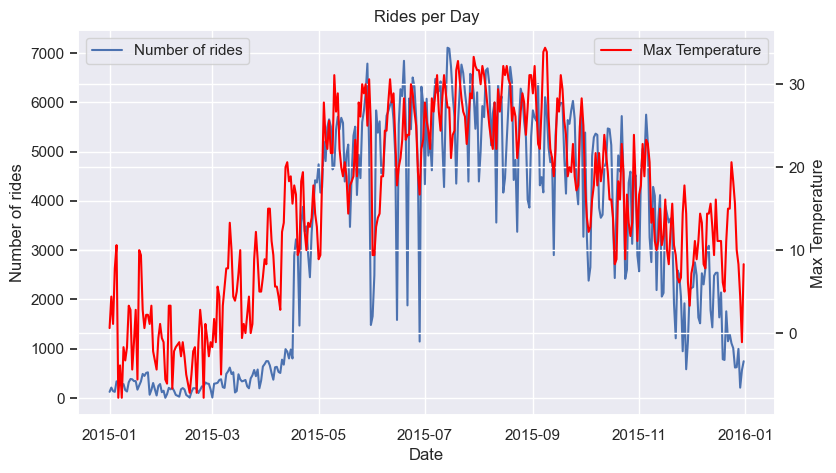

In [143]:
# Data
demand_series = df_boston.groupby(df_boston['start_time'].dt.date).size()
demand_series.index = pd.to_datetime(demand_series.index, format='%Y-%m-%d')

max_temp_day = df_boston.groupby(df_boston['start_time'].dt.date)
max_temp_day.index = pd.to_datetime(demand_series.index, format='%Y-%m-%d')

# Graph
fig = plt.figure()
ax1 = sns.lineplot(demand_series, legend=True)
ax1.set(xlabel='Date', ylabel='Number of rides', title='Rides per Day')
ax1.set_ylabel('Number of rides')
ax1.legend(['Number of rides'], loc="upper left")
ax2 = ax1.twinx()

sns.lineplot(max_temp_day['max_temp'].max('max_temp'), ax=ax2, color='red', legend=True)
ax2.set_ylabel('Max Temperature')
ax2.legend(['Max Temperature'], loc="upper right")

## Rentals per weekday over complete year
This graph shows the number of rentals for every weekday summed over the compete year. We can see, that the highest demand is on thursday and the number of rentals decreases on the weekend

[Text(0.5, 0, 'Weekday'),
 Text(0, 0.5, 'Number of rides'),
 Text(0.5, 1.0, 'Rides per Month')]

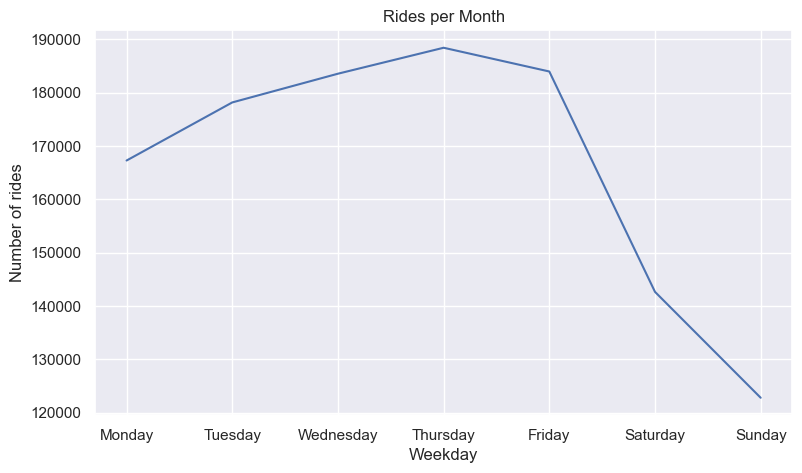

In [144]:
# Data
demand_weekday = df_boston.groupby(df_boston['start_time'].dt.day_name(), sort=True)
grouped_weekdays = demand_weekday.size().reindex(days)

# Graph
ax = sns.lineplot(grouped_weekdays)
ax.set_xticks(grouped_weekdays.index)
ax.set(xlabel='Weekday', ylabel='Number of rides', title='Rides per Month')

## Share of rentals per weekday for every month
In addition to the graph above, we show in this graph the share of rentals for every weekday of the week grouped by the different months over the complete year.

[Text(0, 0.5, 'Percent of rentals of the week'), Text(0.5, 0, 'Weekdays')]

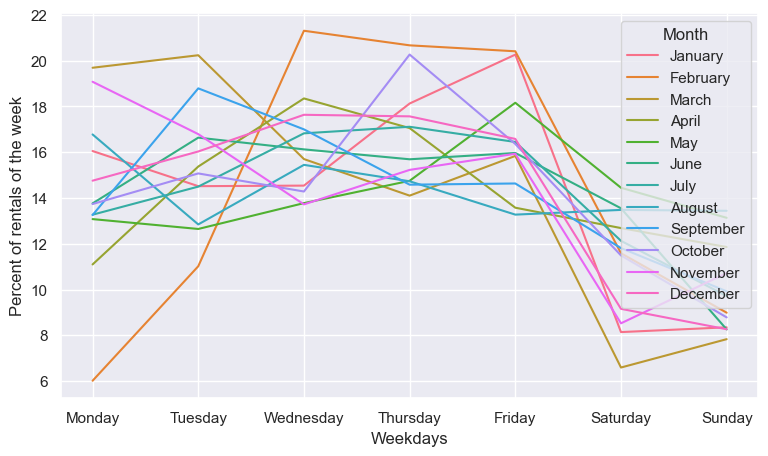

In [170]:
df_rentals_month_weekday = df_boston.copy()

# Add Column Month with the month of each ride
df_rentals_month_weekday['Month'] = df_rentals_month_weekday['start_time'].dt.month_name()

# Add Column Weekday with the weekday of each ride
df_rentals_month_weekday['Weekday'] = df_rentals_month_weekday['start_time'].dt.day_name()

# Group all rides of the year by Month and Weekday
df_rentals_month_weekday = df_rentals_month_weekday.groupby(['Month', 'Weekday']).size().reset_index(name='num_rides')

summ = df_rentals_month_weekday.groupby('Month')['num_rides'].sum()
df_rentals_month_weekday["percent"] = df_rentals_month_weekday.apply(lambda x: (x['num_rides'] / summ[x['Month']]) * 100, axis=1)

# Transform dtype from object to category
df_rentals_month_weekday.Weekday = pd.Categorical(df_rentals_month_weekday.Weekday, categories=days)
df_rentals_month_weekday = df_rentals_month_weekday.sort_values('Weekday')

# Transform dtype from object to category
df_rentals_month_weekday.Month = pd.Categorical(df_rentals_month_weekday.Month, categories=months)
df_rentals_month_weekday = df_rentals_month_weekday.sort_values('Month')

ax = sns.lineplot(data=df_rentals_month_weekday, x='Weekday', y='percent', hue='Month')
ax.set(ylabel='Percent of rentals of the week', xlabel='Weekdays')

## Rental by UserType by month
Here we group the rentals by month and user type. The proportion is mostly subscriber 64%-70%, only in february is an exception where the share of subscriber increases to 77%.

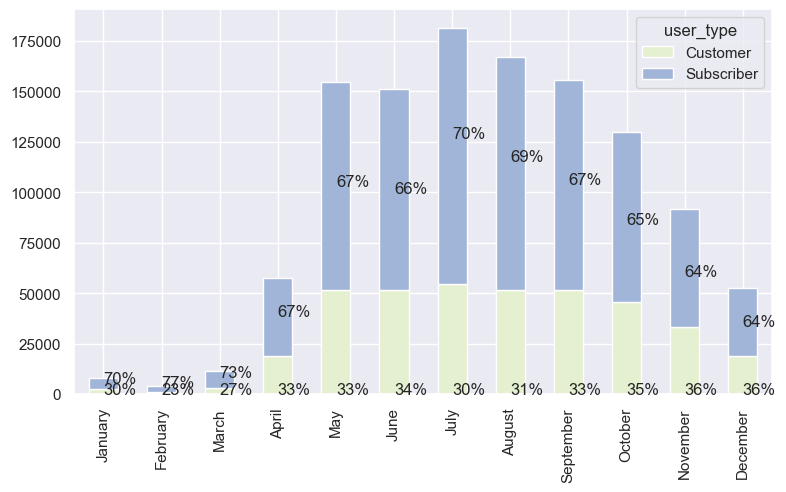

In [146]:
# The grouped pivot table is unstacked, so that every user_type gets a table in a dataframe
months_by_user_type = df_boston.groupby([df_boston["start_time"].dt.month, 'user_type']).size().unstack()
months_by_user_type.index = months

months_by_user_type.plot(kind='bar', stacked=True, color={'Subscriber': '#A1B5D8', 'Customer': '#E4F0D0'})

for index, row in months_by_user_type.iterrows():
    sum = row['Customer'] + row['Subscriber']

    plt.text(x=months.index(index), y=0, s=str(round(row['Customer'] / sum * 100)) + "%")
    plt.text(x=months.index(index), y=row['Subscriber'], s=str(round(row['Subscriber'] / sum * 100)) + "%")

## Rental by Point of Day
In this graph we divided the day into four parts, morning (6-11 oclock), afternoon (12 - 18 oclock), evening (19 - 23 oclock) and night (0 - 5 oclock). And compared the shares of all rentals for the point of day over all months. The proportions only

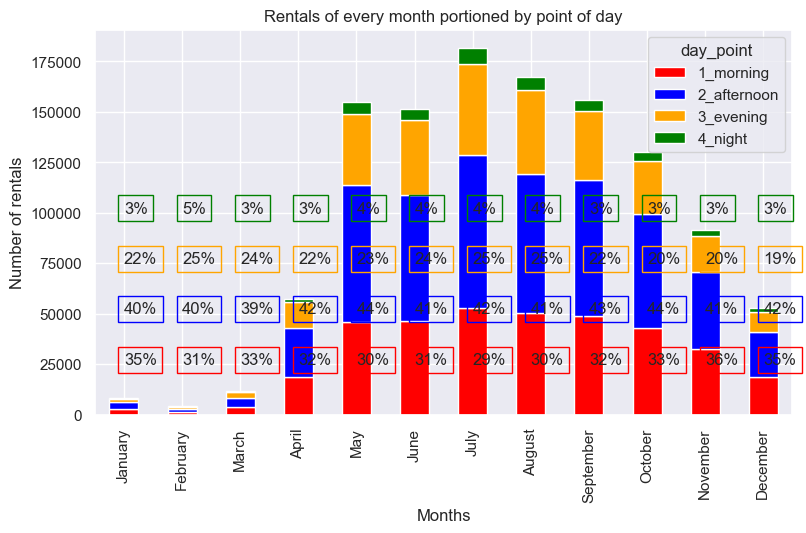

In [147]:
with_point_day = df_boston.copy()
with_point_day["day_point"] = with_point_day["start_time"].dt.hour.apply(lambda x: get_point_of_day(x))

with_point_day = with_point_day.groupby([df_boston["start_time"].dt.month, 'day_point']).size().unstack()
with_point_day.index = months

with_point_day.plot(kind='bar', stacked=True,
                    color={'1_morning': 'red', '2_afternoon': 'blue', '3_evening': 'orange', '4_night': 'green', })

# Graph props
plt.title("Rentals of every month portioned by point of day")
plt.xlabel("Months")
plt.ylabel("Number of rentals")

for index, row in with_point_day.iterrows():
    sum = row['1_morning'] + row['2_afternoon'] + row['3_evening'] + row['4_night']

    # The y values are constant, because the values in Febr. are so small, that the text would overlap when it's centered in the bars height
    plt.text(x=months.index(index), y=25000, s=str(round(row['1_morning'] / sum * 100)) + "%",
             bbox=dict(facecolor='none', edgecolor='red'))
    plt.text(x=months.index(index), y=50000, s=str(round(row['2_afternoon'] / sum * 100)) + "%",
             bbox=dict(facecolor='none', edgecolor='blue'))
    plt.text(x=months.index(index), y=75000, s=str(round(row['3_evening'] / sum * 100)) + "%",
             bbox=dict(facecolor='none', edgecolor='orange'))
    plt.text(x=months.index(index), y=100000, s=str(round(row['4_night'] / sum * 100)) + "%",
             bbox=dict(facecolor='none', edgecolor='green'))

Text(0, 0.5, 'Share of rentals in %')

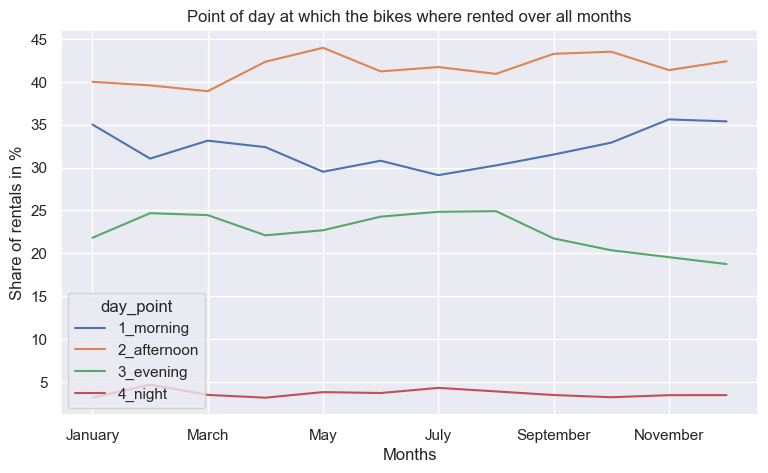

In [148]:
# For each value calculate the share by dividing the value by the sum of complete row
point_of_days_without_sum = with_point_day.loc[:, "1_morning":"4_night"].div(with_point_day.sum(axis=1), axis=0).mul(
    100)
point_of_days_without_sum.index = months
point_of_days_without_sum.plot(kind='line')

# Graph props
plt.title("Point of day at which the bikes where rented over all months")
plt.xlabel("Months")
plt.ylabel("Share of rentals in %")